# Facial Keypoint Detection Demo

**Recommending runing in Google Colab**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/your-username/your-repo/blob/main/notebooks/your-notebook.ipynb)


In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision import models, transforms, datasets
from torchvision.io import read_image

## 1. Load and Visualize Data

In [2]:
!unzip ./data/test.zip

Archive:  ./data/test.zip
  inflating: test.csv                


In [3]:
!unzip ./data/training.zip

Archive:  ./data/training.zip
  inflating: training.csv            


In [4]:
class FacialKeypointsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        keypoint_columns = [
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            'nose_tip_x', 'nose_tip_y',
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y'
        ]
        self.keypoint_columns = [col for col in keypoint_columns if col in self.annotations.columns]



    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, f'{idx}.png')
        if not os.path.exists(img_name):
             return None

        image = Image.open(img_name).convert("L")

        label = self.annotations.loc[idx, self.keypoint_columns].values.astype('float32')

        label[np.isnan(label)] = 0.0

        label = torch.tensor(label)

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
output_dir = 'generated_images'
os.makedirs(output_dir, exist_ok=True)

train_df = pd.read_csv('./training.csv')

for index, row in train_df.iterrows():
    image_pixels = row['Image'].split(' ')
    image_array = np.array([p for p in image_pixels if p != ''], dtype=np.uint8)

    try:
        img = Image.fromarray(image_array.reshape(96, 96), mode='L')
        filename = f'{output_dir}/{index}.png'
        img.save(filename)
    except ValueError as e:
        print(f"Skipping row {index} due to incorrect pixel data length: {e}")
        continue

print(f"Generated {len(train_df)} images in the '{output_dir}' directory.")

Generated 7049 images in the 'generated_images' directory.


## 2. Define Dataset and Transforms

In [6]:
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [7]:
csv_file='training.csv'
root_dir='generated_images'
dataset = FacialKeypointsDataset(csv_file, root_dir, transform=transform)

In [8]:
valid_indices = [i for i in range(len(dataset)) if dataset[i] is not None]
valid_dataset = torch.utils.data.Subset(dataset, valid_indices)

In [9]:
train_size = int(0.8 * len(valid_dataset))
val_size = len(valid_dataset) - train_size
train_set, val_set = random_split(valid_dataset, [train_size, val_size])

In [10]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=128, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 3. Build the Model

In [11]:
class KeypointCNN(nn.Module):
    def __init__(self):
        super(KeypointCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Dropout(0.1)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 10 * 10, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 30)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## 4. Train the Model

In [12]:
device = torch.device('cpu')
model = KeypointCNN().to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [13]:
num_epochs = 5
best_val_loss = float('inf')
epoch = 0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    loss = running_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/5, Training Loss: 657.1006, Validation Loss: 408.3532
Epoch 2/5, Training Loss: 466.0706, Validation Loss: 390.8029
Epoch 3/5, Training Loss: 441.7546, Validation Loss: 425.3676
Epoch 4/5, Training Loss: 417.3843, Validation Loss: 395.4104
Epoch 5/5, Training Loss: 372.2564, Validation Loss: 323.9772


## 5. Evaluate on Validation Set

In [14]:
output_dir = 'test'
os.makedirs(output_dir, exist_ok=True)

train_df = pd.read_csv('./test.csv')

for index, row in train_df.iterrows():
    image_pixels = row['Image'].split(' ')
    image_array = np.array([p for p in image_pixels if p != ''], dtype=np.uint8)

    try:
        img = Image.fromarray(image_array.reshape(96, 96), mode='L')
        filename = f'{output_dir}/{index}.png'
        img.save(filename)
    except ValueError as e:
        print(f"Skipping row {index} due to incorrect pixel data length: {e}")
        continue

print(f"Generated {len(train_df)} images in the '{output_dir}' directory.")

Generated 1783 images in the 'test' directory.


In [15]:
device = torch.device('cpu')
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [16]:
model = KeypointCNN()
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
model.to(device)

KeypointCNN(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.1, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=25600, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=30, bias=True)
  )
)

In [17]:
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [18]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, keypoints in dataloader:
            images, keypoints = images.to(device), keypoints.to(device)
            outputs = model(images)
            loss = criterion(outputs, keypoints.view(outputs.shape))
            total_loss += loss.item()
    return total_loss / len(dataloader)

In [19]:
val_loss = evaluate_model(model, val_loader, criterion, device)
print(f"Validation MSE: {val_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation MSE: 323.9772


## 6. Predict on Test Images

In [85]:
def predict_and_display(model, image_path, device):
    image = Image.open(image_path).convert("L")
    transformed = transform(image).unsqueeze(0).to(device)


    model.eval()
    with torch.no_grad():
        output = model(transformed)
        keypoints = output.view(-1, 2).cpu().numpy()

    display_image = image.resize((96, 96), Image.NEAREST)

    plt.figure(figsize=(6, 6))
    plt.imshow(display_image, cmap='gray')
    plt.scatter(keypoints[:, 0], keypoints[:, 1], c='red', s=20)
    plt.title("Predicted Keypoints")
    plt.axis('off')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

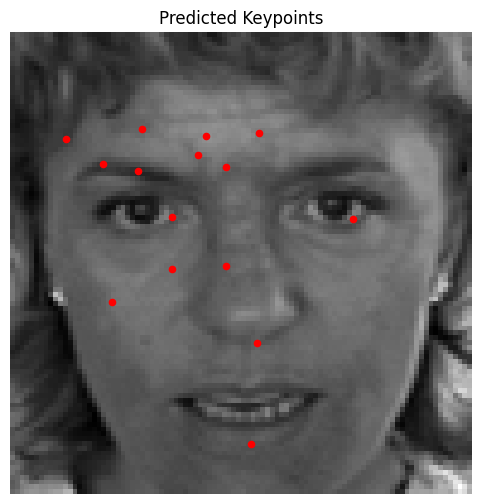

In [86]:
predict_and_display(model, './test/1.png', device)